# OpenPose for Pose Estimation in Greek Vase Paintings

In this notebook we show how to use our implementation of the popular Human Pose Estimation algorithm **OpenPose** [1] to perform human pose estimation in Greek vase painitings.

More precisely, we use a lightweight version of the original model. This lightweight property is obtained by using a MobileNet backbone (instead of a VGG-19) and by reducing the number of refinemet stages (i.e, from 3 to 1). The authors report a Mean Averge Precision of mAP=0.40 on the COCO validation set.

In [33]:
import os
import sys
import json
import collections
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.nn import DataParallel
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

sys.path.append("..")

from data import StyledCoco
import models
from CONFIG import CONFIG
import CONSTANTS
import data
from data.custom_transforms import Normalize, Resize
from lib.inference import multiscale_inference_open_pose
import lib.utils as utils
import lib.metrics as metrics
import lib.pose_parsing as pose_parsing 
import lib.visualizations as visualizations

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
test_exp = "test/experiment_2020-06-04_08-06-38"
test_exp = os.path.join(CONFIG["paths"]["experiments_path"], test_exp)

# Loading Images

Loading and preprocessing two images corresponding to two antique Greek vases

In [80]:
data_path = os.path.join(os.getcwd(), "resources")
img1_path = os.path.join(data_path, "vase4.jpg")
img2_path = os.path.join(data_path, "vase5.jpg")

In [81]:
img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)
img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)

normalize = Normalize(mean=(128, 128, 128), std=256)
resize = Resize(size=600)

img1 = normalize(resize(img1)).transpose(2,0,1)
img2 = normalize(resize(img2)).transpose(2,0,1)
imgs = torch.Tensor([img1, img2])

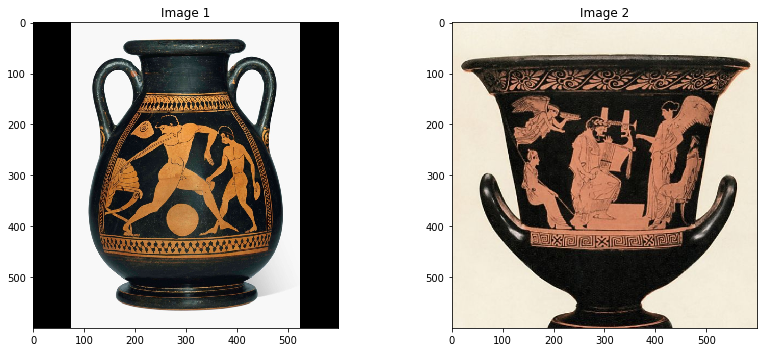

In [82]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,5)
visualizations.visualize_image(img1, ax=ax[0], title="Image 1", bgr=True)
visualizations.visualize_image(img2, ax=ax[1], title="Image 2", bgr=True)

plt.tight_layout()
plt.show()

# Model

Loading the pretrained OpenPose model and predicting heatmaps and PAFs for the input images

In [83]:
model = models.OpenPose()
pretrained_path = os.path.join(CONFIG["paths"]["pretrained_path"], "OpenPose", "checkpoint_iter_370000.pth")
model.load_pretrained(pretrained_path)

In [84]:
# we set the model to use the GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"  # for just one image we can simply use 'cpu'
model = model.to(device)
model = model.eval()

In [85]:
scales = [0.5, 1, 1.5, 2]
heatmaps, pafs = multiscale_inference_open_pose(model=model, imgs=imgs, scales=scales,
                                                image_size=600, device=device, model_name="OpenPose")

# Pose Parsing

We now extract the predicted keypoint coordinates from the heatmaps, display the intermediate results (keypoints and pafs) and parse the estimated human poses.

In [86]:
pose_parsing.BODY_PARTS_PAF_IDS = CONSTANTS.BODY_PARTS_PAF_IDS_OPEN_POSE
pose_parsing.SKELETON = CONSTANTS.SKELETON_OPEN_POSE

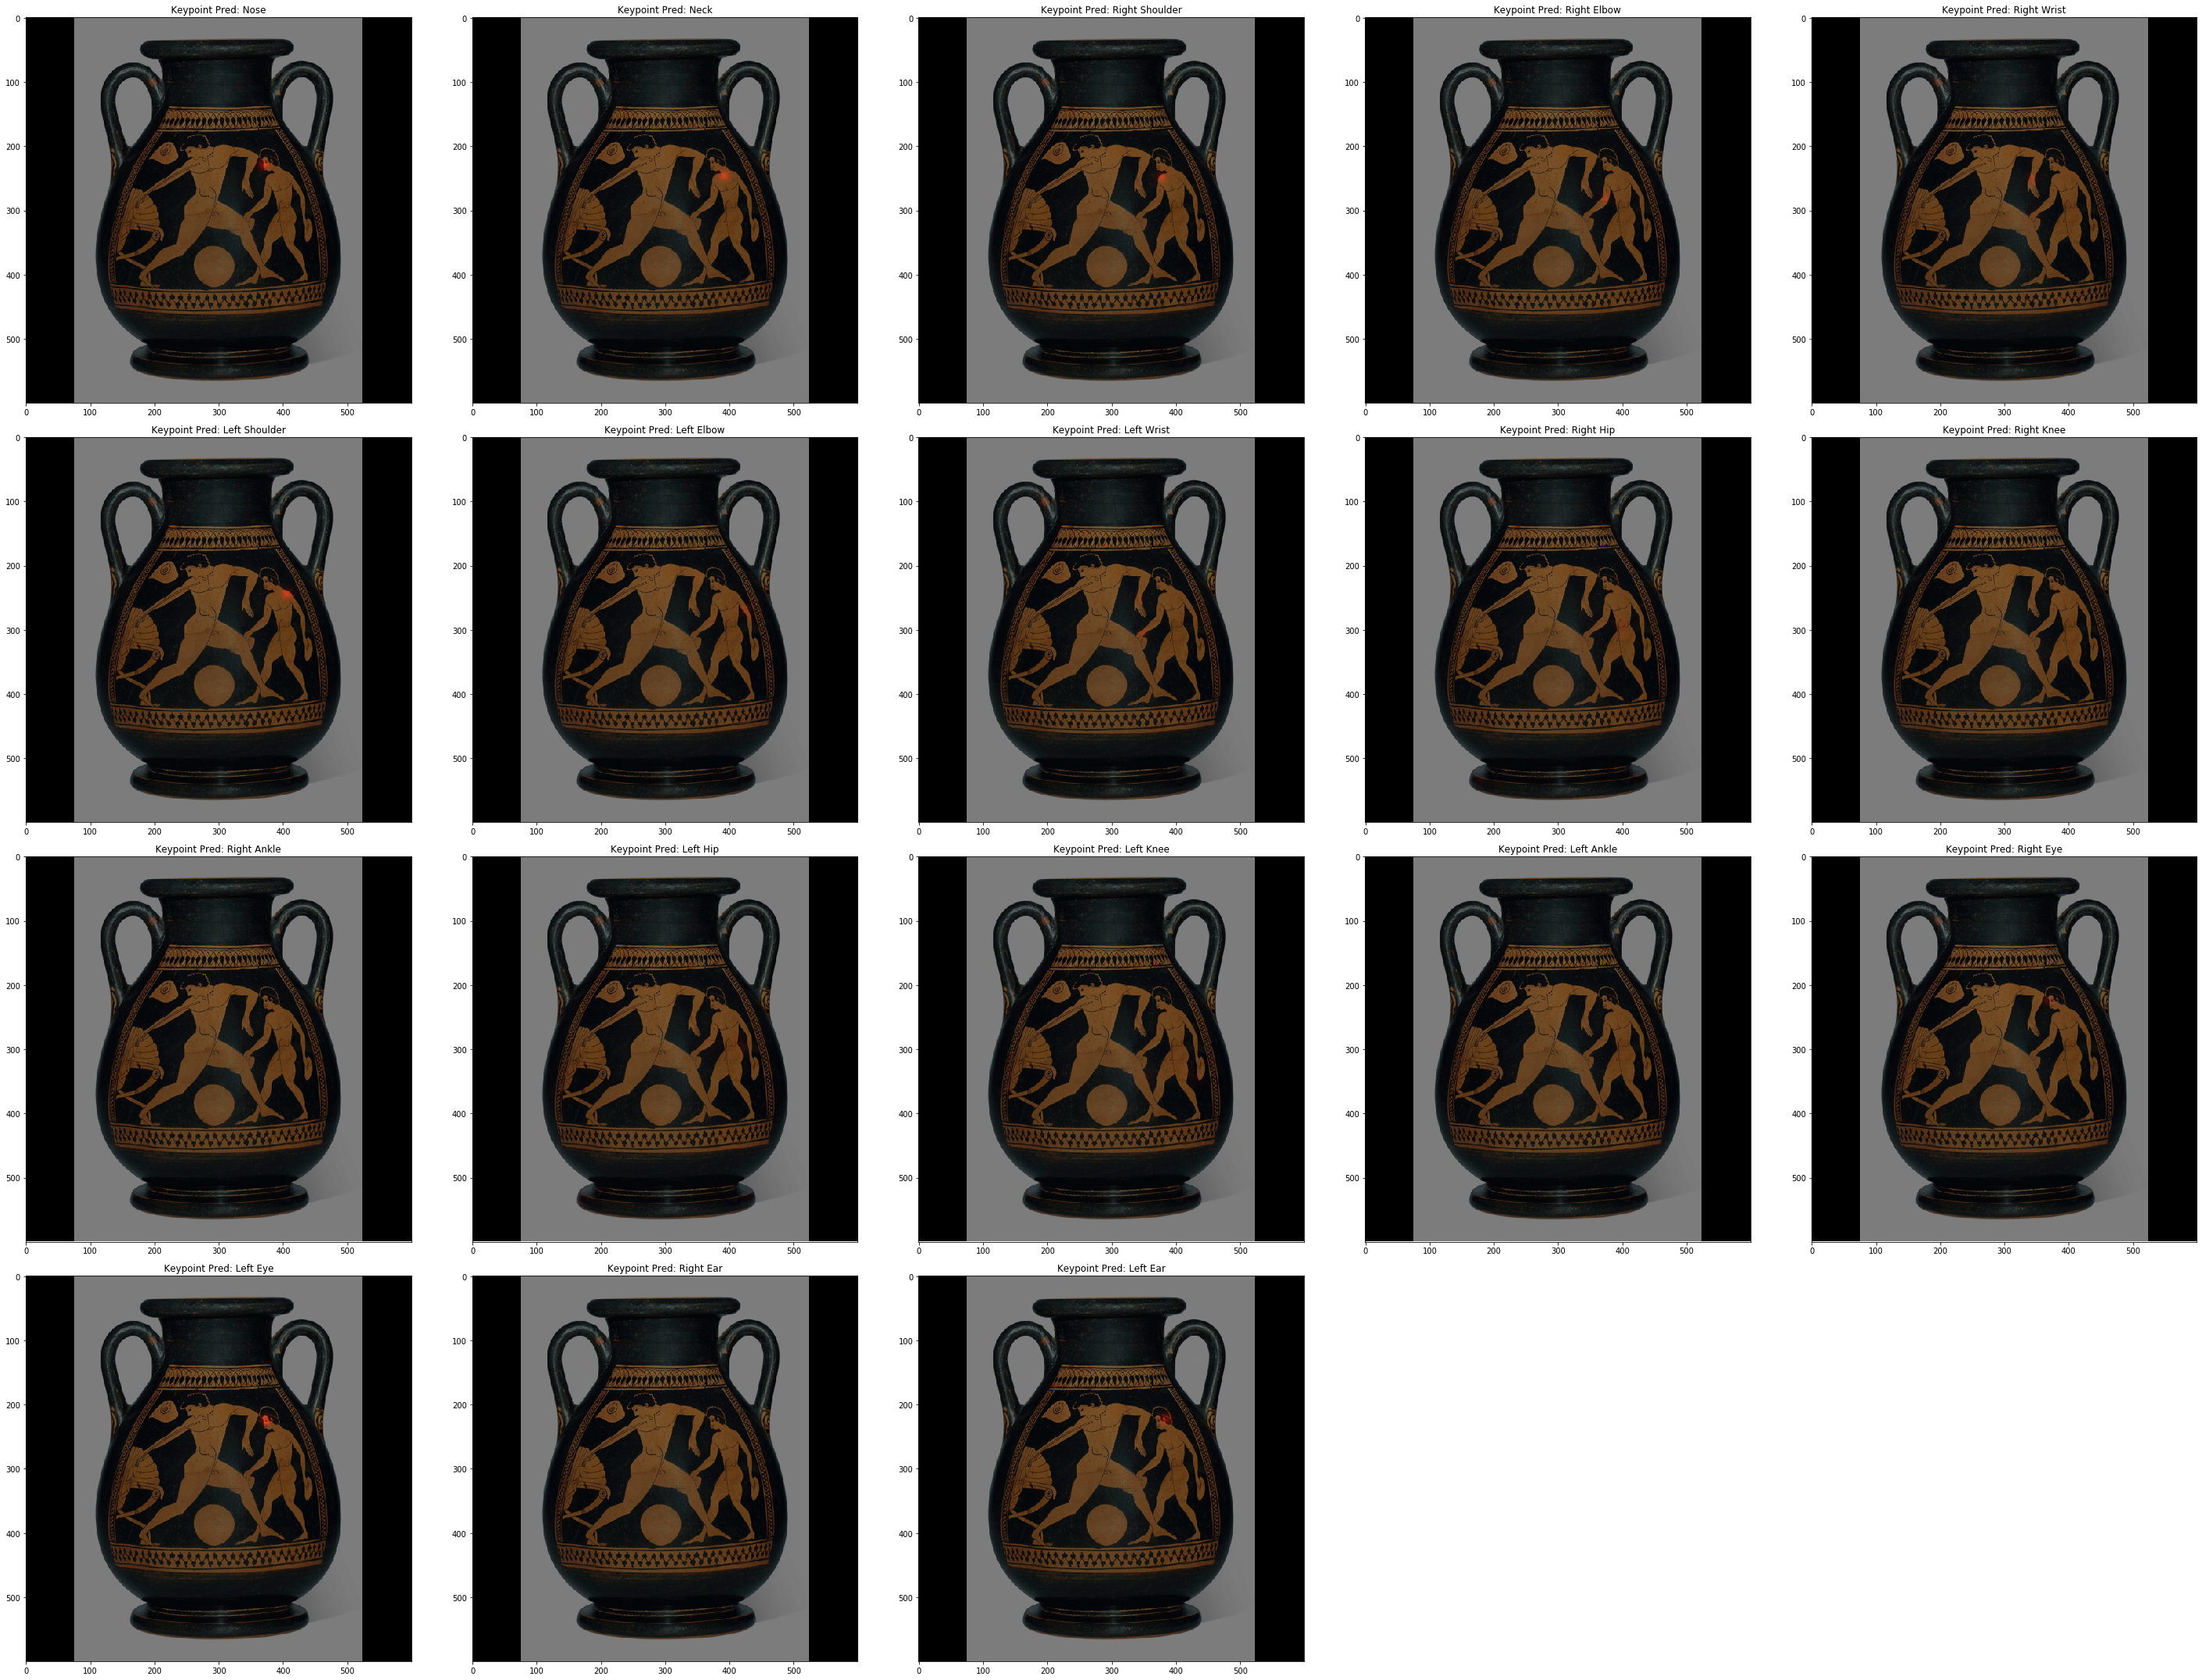

In [87]:
plt.figure(figsize=(40,30))
for i in range(18):
    plt.subplot(4,5,i+1)
    ax = plt.gca()
    title = f"Keypoint Pred: {CONSTANTS.IDX_TO_KPT_NAME_OPEN_POSE[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(heatmaps[0,i,:]), img=img1, ax=ax, title=title, bgr=True)
plt.tight_layout()
plt.show()

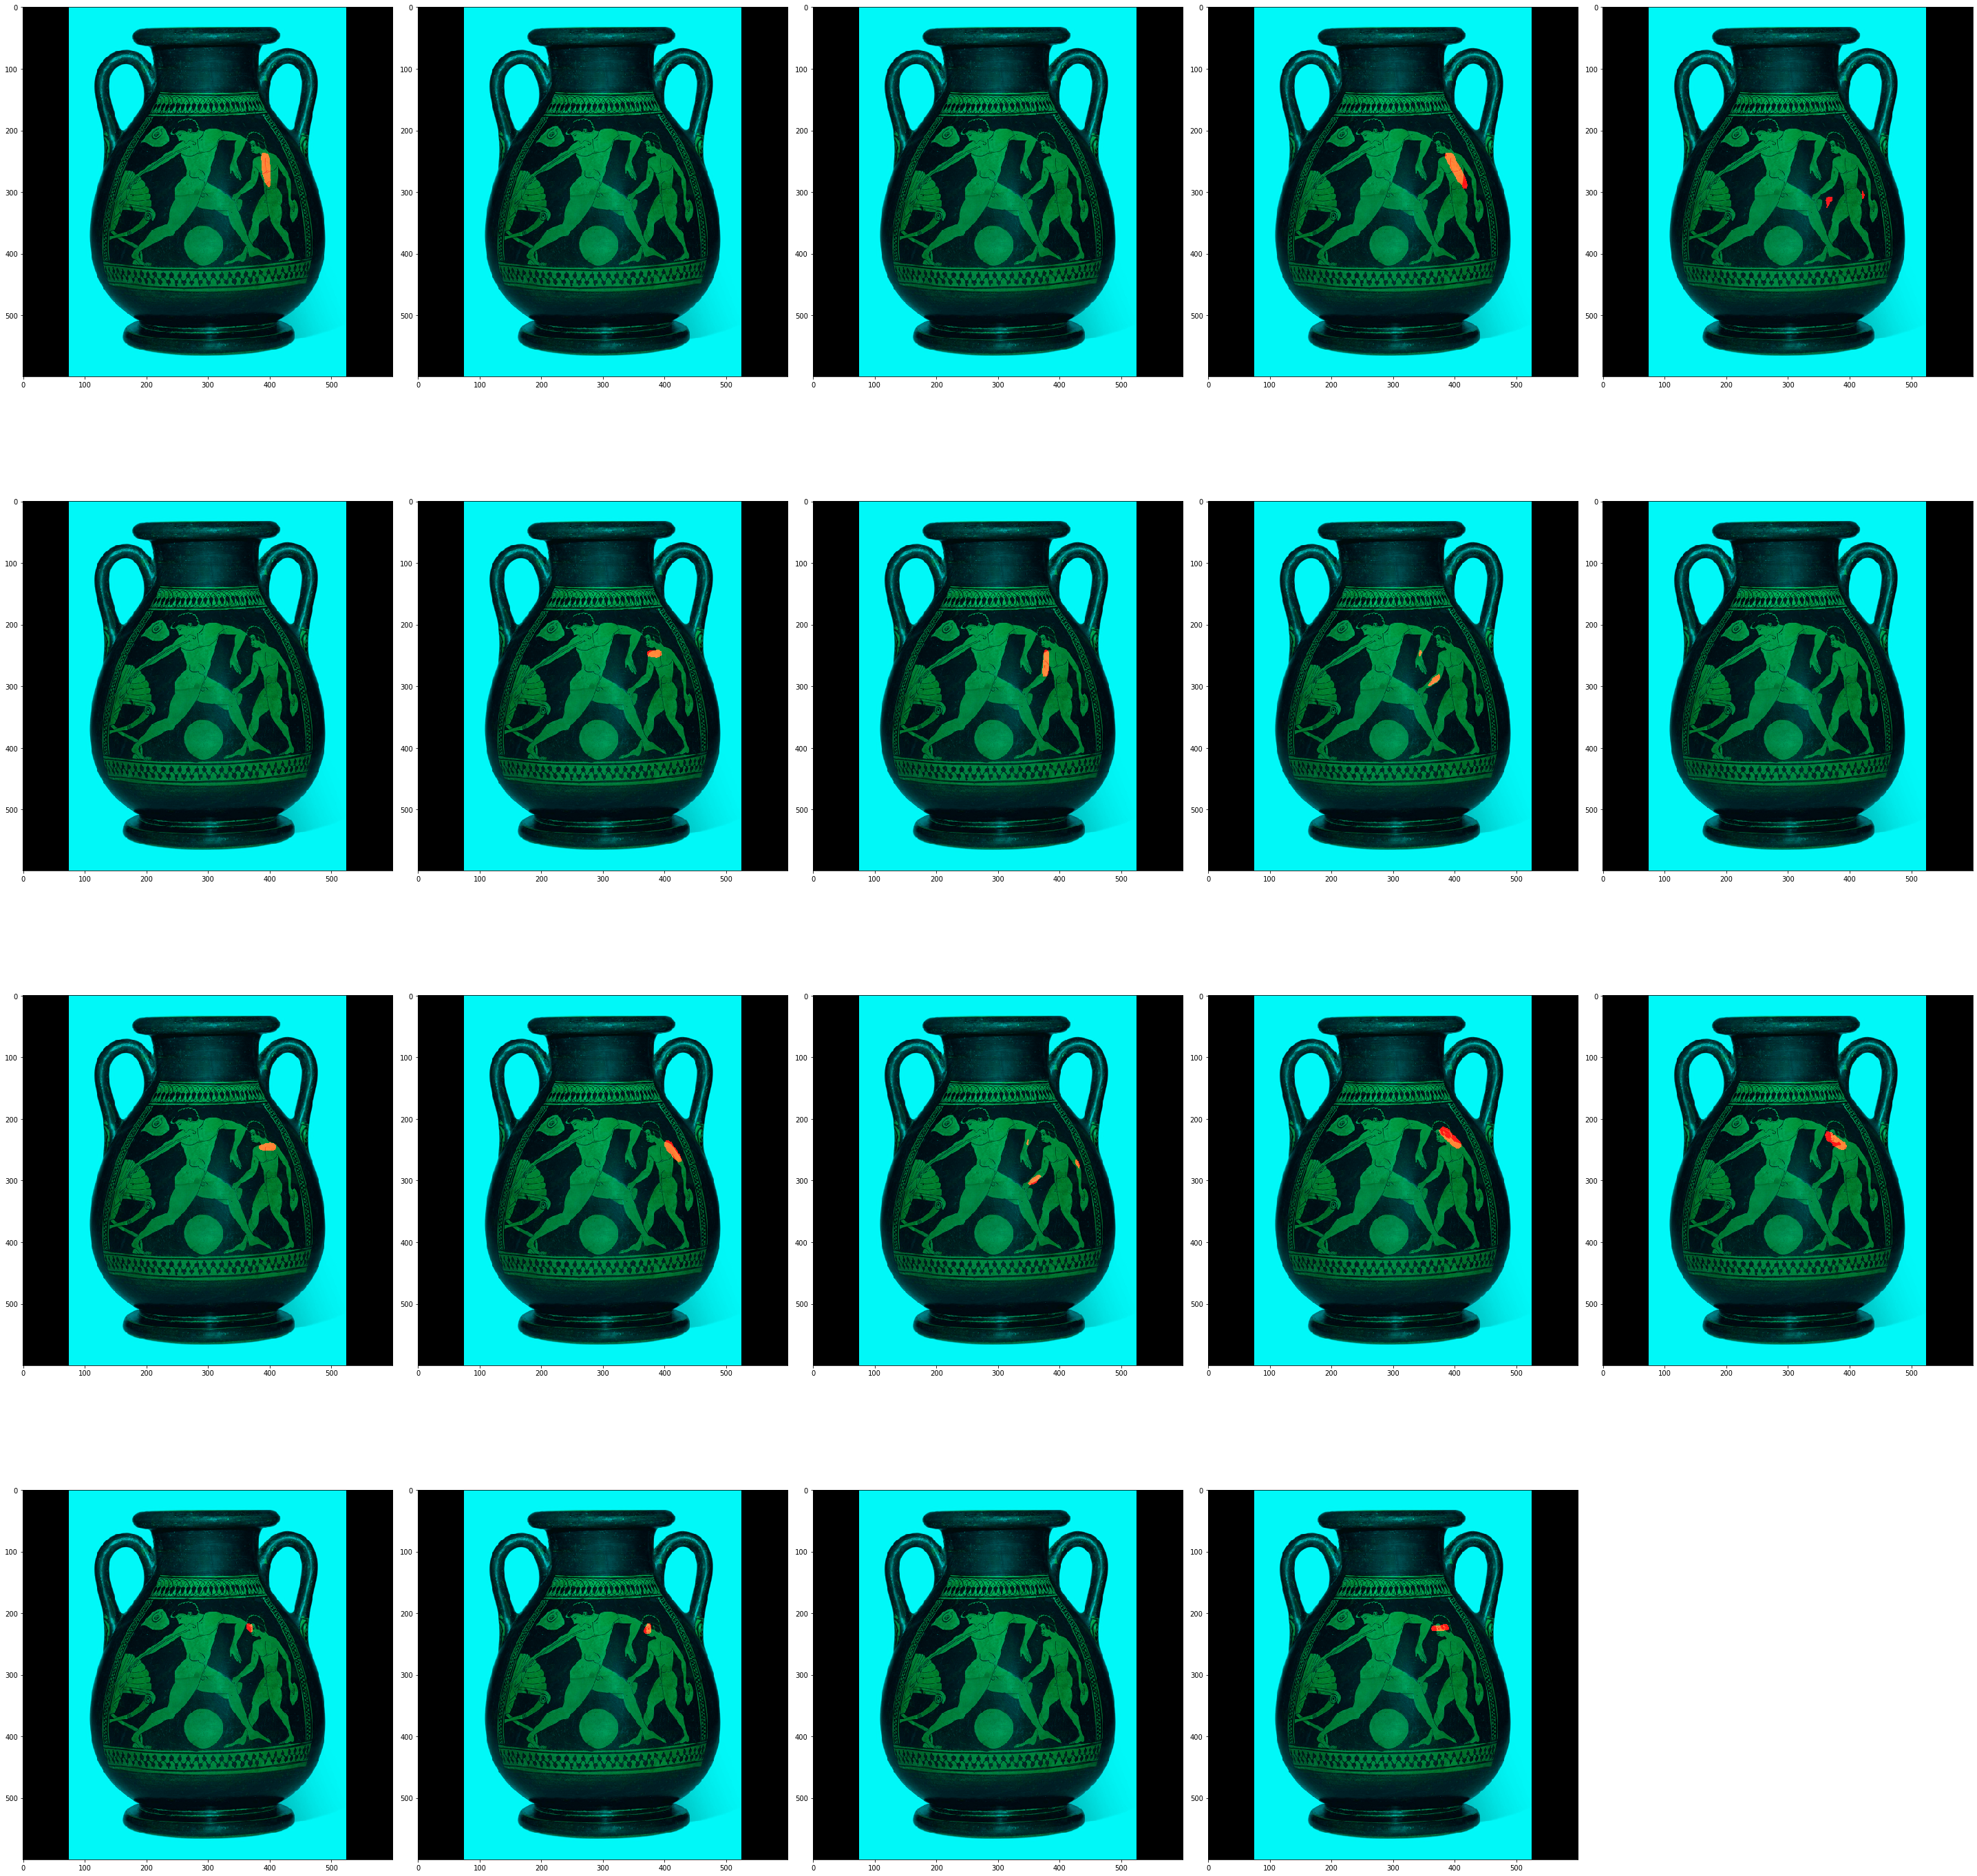

In [88]:
plt.figure(figsize=(40,60))
for i in range(19):
    plt.subplot(6,5,i+1)
    ax = plt.gca()
    visualizations.overlay_paf(pafs=pafs[0,2*i:2*i+2,:], img=img1, ax=ax, bgr=True)
plt.tight_layout()
plt.show()

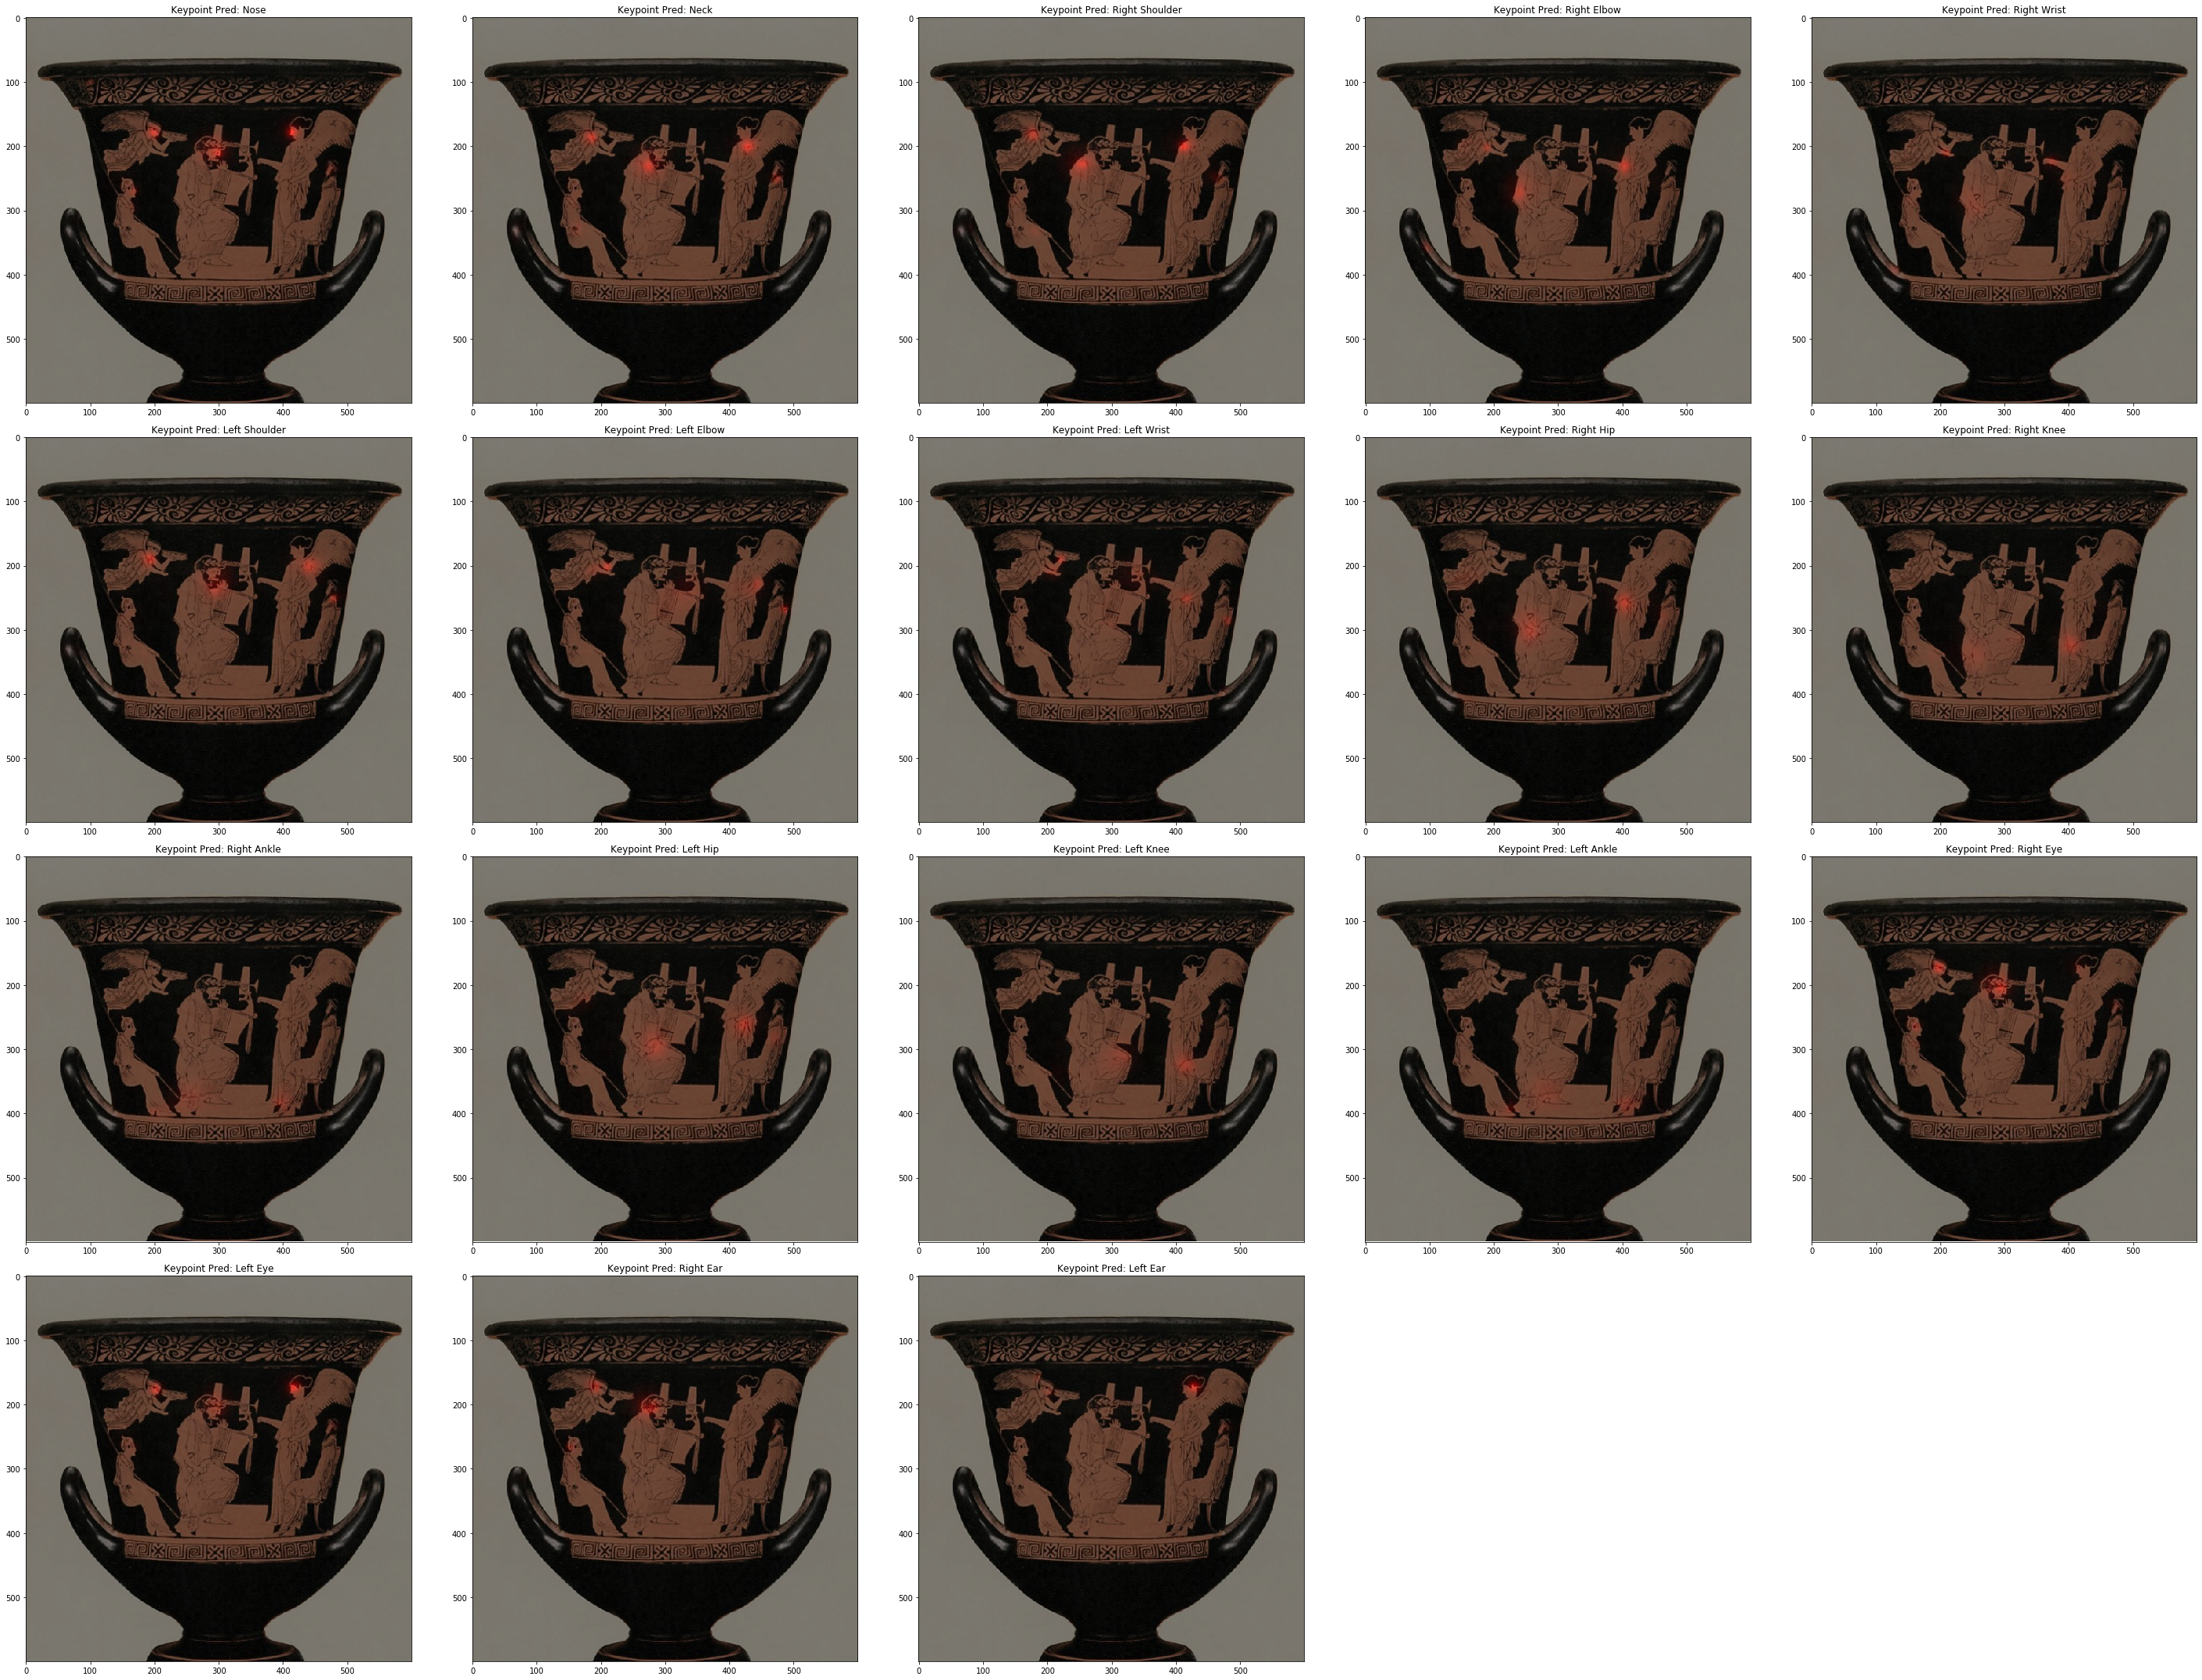

In [89]:
plt.figure(figsize=(40,30))
for i in range(18):
    plt.subplot(4,5,i+1)
    ax = plt.gca()
    title = f"Keypoint Pred: {CONSTANTS.IDX_TO_KPT_NAME_OPEN_POSE[i]}"
    visualizations.overlay_heatmap(heatmap=np.array(heatmaps[1,i,:]), img=img2, ax=ax, title=title, bgr=True)
plt.tight_layout()
plt.show()

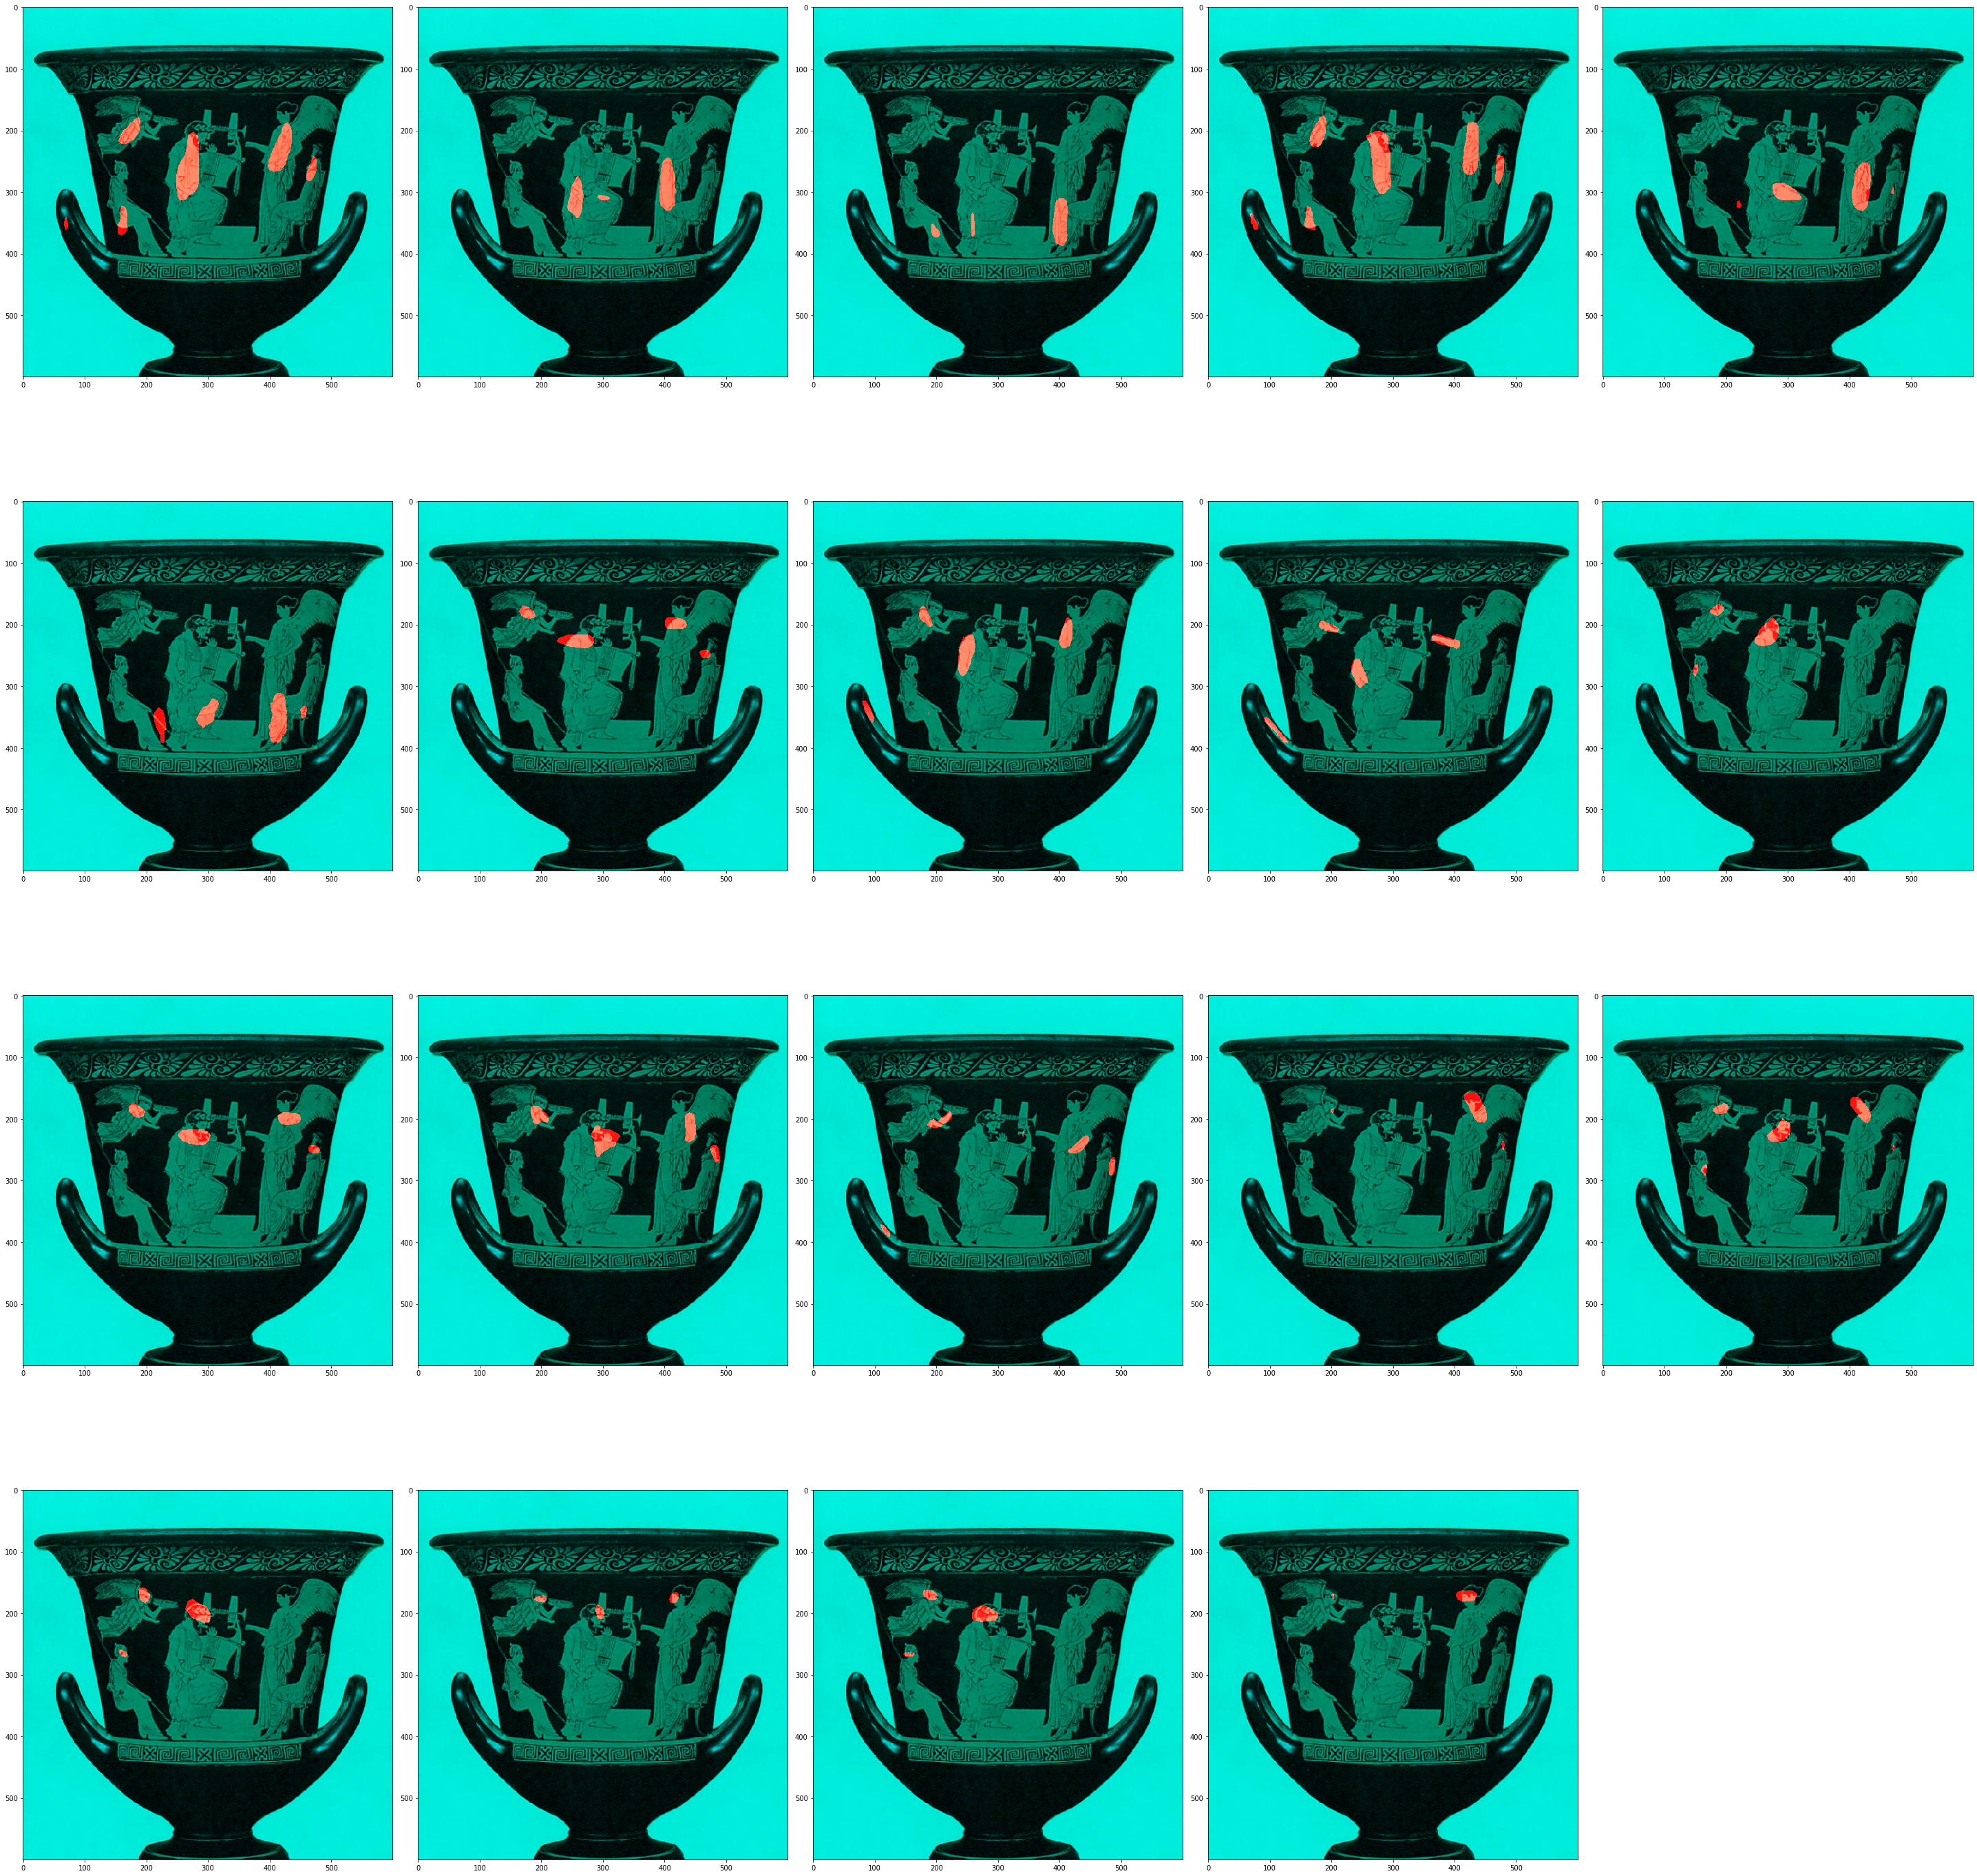

In [90]:
plt.figure(figsize=(40,60))
for i in range(19):
    plt.subplot(6,5,i+1)
    ax = plt.gca()
    visualizations.overlay_paf(pafs=pafs[1,2*i:2*i+2,:], img=img2, ax=ax, bgr=True)
plt.tight_layout()
plt.show()

In [91]:
coords_1, keypoints_1 = pose_parsing.extract_joins_heatmap(heatmaps[0,:], min_distance=1, thr=0.3)
coords_2, keypoints_2 = pose_parsing.extract_joins_heatmap(heatmaps[1,:], min_distance=1, thr=0.3)

In [92]:
pose_entries_1, all_keypoints_1, pose_entries_1_aux = pose_parsing.group_keypoints(keypoints_1, pafs[0,:],
                                                                                   min_paf_score=0.05, thr_ratio=0.8, debug=True)
pose_entries_2, all_keypoints_2, pose_entries_2_aux = pose_parsing.group_keypoints(keypoints_2, pafs[1,:],
                                                                                   min_paf_score=0.05, thr_ratio=0.8, debug=True)

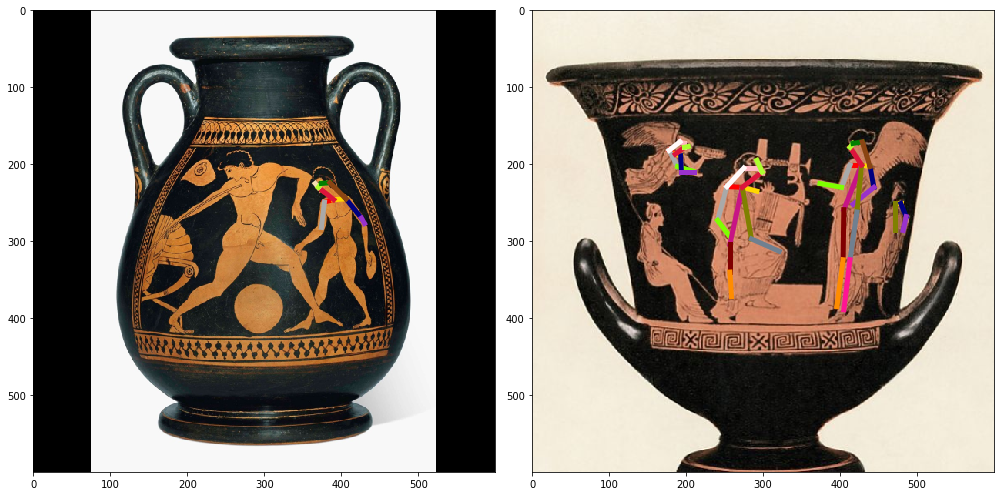

In [93]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(14, 7)

title = "Poses Image 1"
visualizations.draw_pose(img1, pose_entries_1, all_keypoints_1, ax=ax[0], title=title, preprocess=True, bgr=True)


title = "Poses Image 2"
visualizations.draw_pose(img2, pose_entries_2, all_keypoints_2, ax=ax[1], title=title, preprocess=True, bgr=True)

plt.tight_layout()
plt.show()

# References

[1] Cao, Zhe, et al. *Realtime multi-person 2d pose estimation using part affinity fields.* Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.

[2] Osokin, Daniil. *Real-time 2d multi-person pose estimation on CPU: Lightweight OpenPose.* arXiv preprint arXiv:1811.12004 (2018).

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 